In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, e

## Load data

In [90]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [91]:
# 7000 data with 300 features
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(7000, 300)
(7000,)
(3000, 300)


In [92]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [93]:
def cross_validation(x_train, y_train, k=5):
    sample_size = x_train.shape[0]
    fold_size = np.ones(k , dtype=int) * (sample_size // k) 
    fold_size[:sample_size % k] += 1 # if the sample size is not divisible by k
    # shuffle
    indexs = np.arange(sample_size)
    np.random.default_rng(seed=1).shuffle(indexs)
    folds = np.array_split(indexs, k)
    folds = np.array(folds)

    # return training index and val index in each fold
    ret = []
    for i in range(k):
        train_fold_ind = np.delete(np.arange(k), i)
        train_fold = np.concatenate((folds[train_fold_ind]), axis=None) 
        val_fold = folds[i]
        ret.append([train_fold, val_fold])
    return ret

In [94]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [95]:
X = np.arange(20)
kfold_data_example = cross_validation(X, X, k=5)
for i, (train_index, val_index) in enumerate(kfold_data_example):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))

Split: 1, Training index: [ 7 11 12 17 15  2  3  4  5  8  0  9 14 13  6 19], Validation index: [ 1 10 18 16]
Split: 2, Training index: [ 1 10 18 16 15  2  3  4  5  8  0  9 14 13  6 19], Validation index: [ 7 11 12 17]
Split: 3, Training index: [ 1 10 18 16  7 11 12 17  5  8  0  9 14 13  6 19], Validation index: [15  2  3  4]
Split: 4, Training index: [ 1 10 18 16  7 11 12 17 15  2  3  4 14 13  6 19], Validation index: [5 8 0 9]
Split: 5, Training index: [ 1 10 18 16  7 11 12 17 15  2  3  4  5  8  0  9], Validation index: [14 13  6 19]


In [96]:
assert len(kfold_data_example) == 5 # should contain 5 fold of data
assert len(kfold_data_example[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data_example[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [116]:
# cross validation
kfold_data = cross_validation(x_train, y_train, k=5)

possible_C = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
possible_gamma = [0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

avg_score = np.zeros((len(possible_C), len(possible_gamma)))
best_score = 0
best_model = None
best_parameters = [0, 0]
# hyperparameters

for i in range(len(possible_C)):
    for j in range(len(possible_gamma)):
        score = 0
        # use cross validation data to train and evaluate the model performance
        clf = SVC(C=possible_C[i], kernel='rbf', gamma=possible_gamma[j])
        for train_index, val_index in kfold_data:
            clf.fit(x_train[train_index], y_train[train_index])
            score += clf.score(x_train[val_index], y_train[val_index])

        avg_score[i][j] = score / len(kfold_data)
        
        # record the best model
        if avg_score[i][j] > best_score:
            best_score = avg_score[i][j]
            best_model = clf
            best_parameters = [possible_C[i], possible_gamma[j]]


In [117]:
print('best score: ', best_score)
print(best_parameters[0], best_parameters[1])

best score:  0.9932857142857143
0.9 9e-05


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [86]:
import matplotlib.pyplot as plt

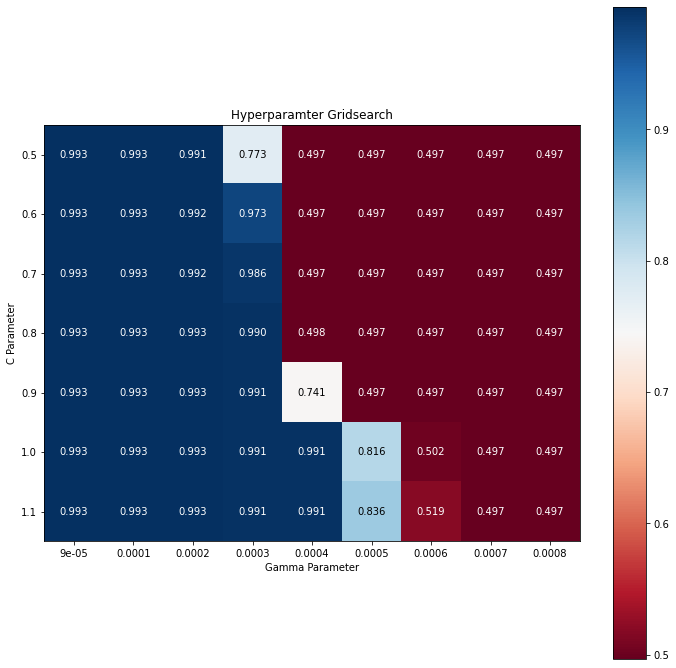

In [118]:
# Plot the grid search results of my SVM
plt.figure(figsize=(12, 12))
plt.imshow(avg_score, cmap='RdBu', interpolation='nearest')
plt.xticks(np.arange(len(possible_gamma)), possible_gamma)
plt.yticks(np.arange(len(possible_C)), possible_C)
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
plt.title("Hyperparamter Gridsearch")
plt.colorbar()

# add validation score to the heatmap
for i in range(len(possible_C)):
    for j in range(len(possible_gamma)):
        if avg_score[i][j] > 0.7 and avg_score[i][j] <= 0.9:
            c = 'black'
        else:
            c = 'white'
        plt.text(j, i, f'{avg_score[i][j]:.3f}', ha='center', va='center', color=c)

plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [ ]:
best_model = SVC(C=5, kernel='rbf', gamma=0.002)
best_model.fit(x_train, y_train)

In [ ]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))